In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [2]:
from src.segmentation.roi import RoIAlign
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold
from src.utils.utils import split_custom_filename
from src.segmentation import cam
from src.classifier.agent import load_trainer
from src.segmentation.cam import CAMS
from src.segmentation import segmentation
import nibabel as nib


import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
trainer, dataset, model = load_trainer('resnet50', checkpoint_path="/logs/tb/resnet50/version_5/checkpoints/checkpoint-v1.ckpt");

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_5/checkpoints/checkpoint-v1.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"class_weights":       None
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 1e-05, 'amsgrad': False}}
Dataset sizes - Training: 421 Validation: 47


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.


In [4]:
filename= '../data/SPM_categorised/AIH/CN/CN_ADNI_0443.nii'
class_label = split_custom_filename(filename,'/')[4]
tmp_image = nib.load(filename).get_fdata()
tmp = cam.CAM(CAMS.GradCAM.value, model, image2axial(tmp_image))

grid_image, grid_mask = tmp.grid_class(tmp.class_scores, 2, pad_value=0, max_num_slices=None)

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


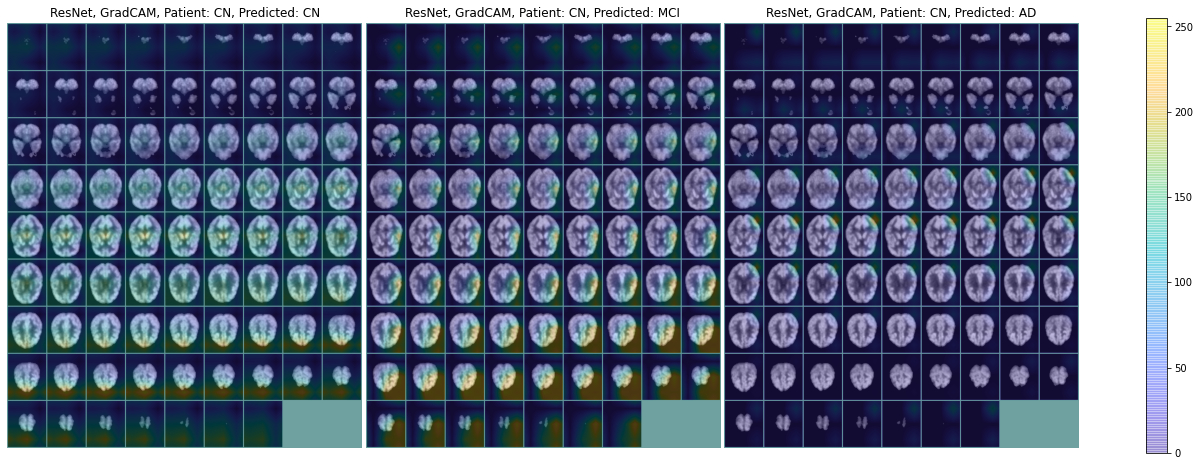

In [5]:
tmp.plot(tmp.class_scores, [0,1,2],max_num_slices=None, class_label=class_label);

# Get mask activations

In [6]:
masked_image = tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))

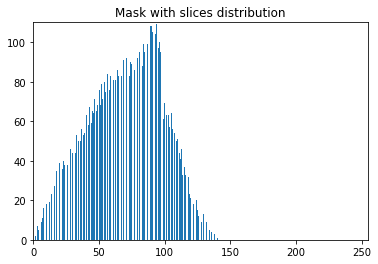

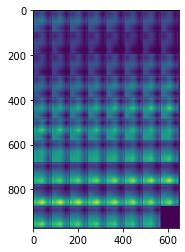

In [7]:
# Only check the distribution from each image! This looks a lot better!
segmentation.intensity_distribution(tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))[30].flatten(),title="Mask with slices distribution")

sliced_masks = tmp.preprocess(tmp.activation_map(0, tmp.class_scores))
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(sliced_masks).unsqueeze(1), nrow=8)[0])

## Test of thresholding

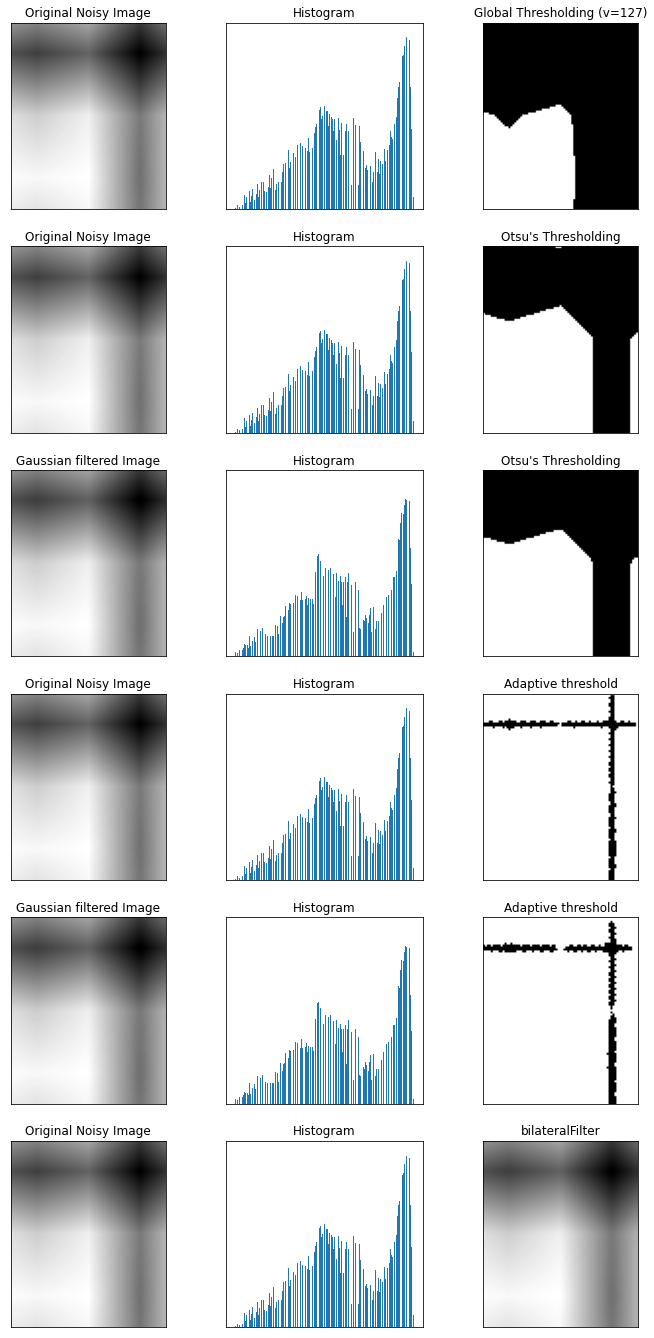

In [131]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = sliced_masks[50].copy()

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Adaptive threshold
th4 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

# Adaptive threshold after Gaussian filtering
th5 = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

th6 = cv.bilateralFilter(img,5,100,100)
#th6 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [
    img, 0, th1,
    img, 0, th2,
    blur, 0, th3,
    img, 0, th4,
    blur, 0, th5,
    img, 0, th6,
]
titles = [
    'Original Noisy Image','Histogram','Global Thresholding (v=127)',
    'Original Noisy Image','Histogram',"Otsu's Thresholding",
    'Gaussian filtered Image','Histogram',"Otsu's Thresholding",
    'Original Noisy Image','Histogram',"Adaptive threshold",
    'Gaussian filtered Image','Histogram',"Adaptive threshold",
    'Original Noisy Image','Histogram',"bilateralFilter",
]
rows = len(images)//3
fig = plt.figure(figsize=(12,4*rows))

for i in range(rows):
    plt.subplot(rows,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(rows,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(rows,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Notes:
Otsu and global thresholding does not fix the problem.

# Fuse multiple scans

In [132]:
def extract_image_and_labels(filename):
    image = load_nifti_axial(filename)
    label = split_custom_filename(filename,'/')[4]
    return image, label

In [ ]:
import warnings
# Get all images (maybe use the dataloader?)
from src.utils.load import load_files, load_nifti_axial



# Load all image filenames
all_image_paths = load_files('../data/SPM_categorised/AIH/')

# Setup extractor
first_image, class_label = extract_image_and_labels(all_image_paths[0])
cam_extractor = cam.CAM(CAMS.GradCAM.value, model, first_image)


# Calculate the CAM for each image
cam_storage = {
    'CN':[],
    'MCI':[],
    'AD':[]
}
image_storage = {
    'CN':[],
    'MCI':[],
    'AD':[]
}
labels = {
    'CN':0,
    'MCI':1,
    'AD':2
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for index, filename in enumerate(all_image_paths[1:]):
        image, label = extract_image_and_labels(filename)
        cam_extractor.image = image
        cam_extractor.evaluate()

        mask = tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))
        cam_storage[label].append(mask)
        image_storage[label].append(image)
        print(", ".join(["Index:",str(index),filename]), end='\r')
        
# Store the CAM in a list or something

# Store ref image so we can remove background. Assume the images might have small deviations in shape

# Take the average of all CAMS

# Calculate boundaries!

# Done?



In [ ]:
merged_mask = np.concatenate(cam_storage['AD'])
merged_image = np.concatenate(image_storage['AD'])

In [ ]:
plt.imshow(merged_mask[200])

In [ ]:
merged_mask.shape

In [ ]:
merged_image.shape

In [ ]:
# Note: Needs optimizations 
features = sequential_processing(merged_image, merged_mask)

# Extract Segmentation and boundary boxes

asdasd 28 76 (28, 27, 4, 76, 93, 60)
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
(48.67633166534163, 59.7744236075387, 31.006944769209184)
asdasd 36 37 (36, 40, 4, 37, 41, 5)
36
(36.0, 40.0, 4.0)
asdasd 41 42 (41, 80, 14, 42, 81, 15)
41
(41.0, 80.0, 14.0)
asdasd 41 42 (41, 82, 15, 42, 83, 16)
41
(41.0, 82.0, 15.0)
asdasd 41 42 (41, 86, 19, 42, 87, 20)
41
(41.0, 86.0, 19.0)


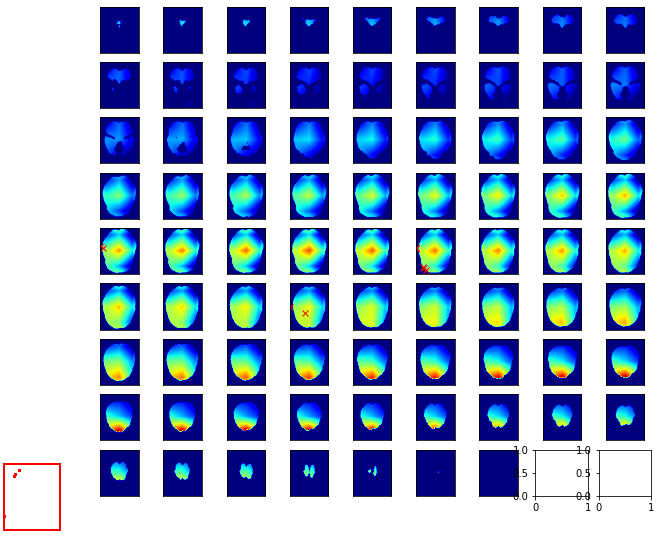

In [8]:
image, image_mask = tmp.image, sliced_masks
# Remove mask that we know are a background (not a part of the brain scan)
mask_no_background = segmentation.remove_known_background_from_mask(image, image_mask)

# Rescale mask and segment it
mask_mean = segmentation.mask_logarithmic_scale(mask_no_background)
segmented_mask = segmentation.segment_mask(mask_mean)

# Extract features with the intensities of the mask with removed background and plot it
features = segmentation.extract_features(segmented_mask, mask_no_background)
segmentation.plot_features_regions(features, mask_no_background)

asdasd 28 76 (28, 27, 4, 76, 93, 60)
Centroid (48.67633166534163, 59.7744236075387, 31.006944769209184)
asdasd 36 37 (36, 40, 4, 37, 41, 5)
Centroid (36.0, 40.0, 4.0)
asdasd 41 42 (41, 80, 14, 42, 81, 15)
Centroid (41.0, 80.0, 14.0)
asdasd 41 42 (41, 82, 15, 42, 83, 16)
Centroid (41.0, 82.0, 15.0)
asdasd 41 42 (41, 86, 19, 42, 87, 20)
Centroid (41.0, 86.0, 19.0)


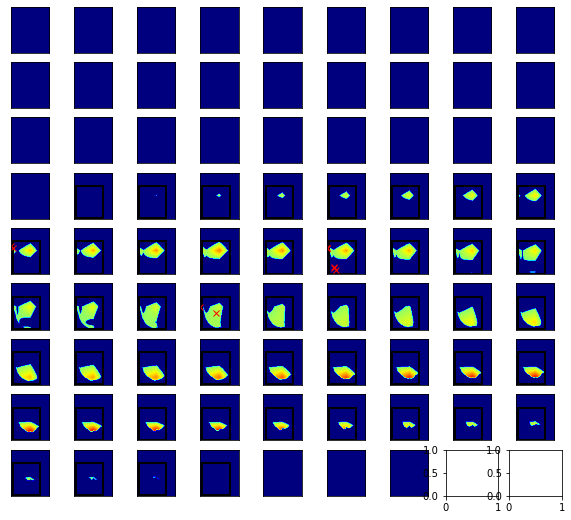

In [88]:
import matplotlib.patches as mpatches
step=1
ncols = 9
nrows = 1 if len(image_mask) == 0 else int(np.ceil(len(image_mask)/ncols))
_, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 1*nrows))

vmin = image_mask.min()
vmax = image_mask.max()

for ax, image in zip(axes.flatten(), mask_no_background[::step]):
    ax.imshow(image, cmap='jet', vmin=vmin, vmax=vmax)

    ax.set_xticks([])
    ax.set_yticks([])

# Add boundaries
flatten_axis = axes.flatten()
for feature in features:
    y0, x0, y1, x1,z0, z1 = segmentation.bounding_boxes(feature)
    #rect = mpatches.Rectangle((x0, y0), x1 - x0, y1 - y0,fill=False, edgecolor='red', linewidth=2)
    print("asdasd",z0,z1, feature.bbox)
    for z in range(z0,z1):

        flatten_axis[z].add_patch(mpatches.Rectangle((x0, y0), x1 - x0, y1 - y0,fill=False, edgecolor='red', linewidth=2))
        

    print("Centroid",feature.centroid)
    #Note check that these coordinates are correct!
    flatten_axis[int(feature.centroid[0])].plot(*feature.centroid[::-1], marker='x', color='r')

In [80]:
flatten_axis[41].pat

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

In [73]:
flatten_axis[28].add_patch(rect)
flatten_axis[28].add_patch(rect)

In [37]:
from skimage.measure import regionprops_table,regionprops
regionprops_table(segmented_mask, mask_no_background,properties=('centroid','slice','bbox','major_axis_length','minor_axis_length'))

{'centroid-0': array([48.67633167, 36.        , 41.        , 41.        , 41.        ]),
 'centroid-1': array([59.77442361, 40.        , 80.        , 82.        , 86.        ]),
 'centroid-2': array([31.00694477,  4.        , 14.        , 15.        , 19.        ]),
 'slice': array([(slice(28, 76, None), slice(27, 93, None), slice(4, 60, None)),
        (slice(36, 37, None), slice(40, 41, None), slice(4, 5, None)),
        (slice(41, 42, None), slice(80, 81, None), slice(14, 15, None)),
        (slice(41, 42, None), slice(82, 83, None), slice(15, 16, None)),
        (slice(41, 42, None), slice(86, 87, None), slice(19, 20, None))],
       dtype=object),
 'bbox-0': array([28, 36, 41, 41, 41]),
 'bbox-1': array([27, 40, 80, 82, 86]),
 'bbox-2': array([ 4,  4, 14, 15, 19]),
 'bbox-3': array([76, 37, 42, 42, 42]),
 'bbox-4': array([93, 41, 81, 83, 87]),
 'bbox-5': array([60,  5, 15, 16, 20]),
 'major_axis_length': array([71.3827775,  0.       ,  0.       ,  0.       ,  0.       ]),
 'minor_

In [38]:
derp = regionprops(segmented_mask, mask_no_background)

In [54]:
derp[0].bbox

(28, 27, 4, 76, 93, 60)

In [36]:
sliced_masks.shape

(79, 95, 79)

In [174]:
derp[0].coords

array([[28, 45, 39],
       [28, 46, 37],
       [28, 46, 38],
       ...,
       [75, 56, 43],
       [75, 57, 43],
       [75, 57, 44]])

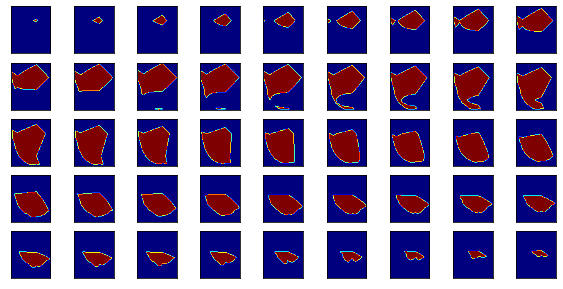

In [171]:
segmentation.display(features[0].image,step=1)

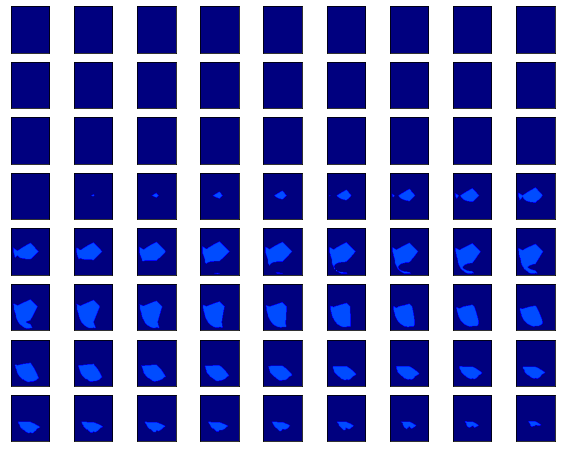

In [139]:
segmentation.display(segmented_mask,step=1)

asdasd 4 60 (28, 27, 4, 76, 93, 60)
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
(48.67633166534163, 59.7744236075387, 31.006944769209184)
asdasd 4 5 (36, 40, 4, 37, 41, 5)
4
(36.0, 40.0, 4.0)
asdasd 14 15 (41, 80, 14, 42, 81, 15)
14
(41.0, 80.0, 14.0)
asdasd 15 16 (41, 82, 15, 42, 83, 16)
15
(41.0, 82.0, 15.0)
asdasd 19 20 (41, 86, 19, 42, 87, 20)
19
(41.0, 86.0, 19.0)


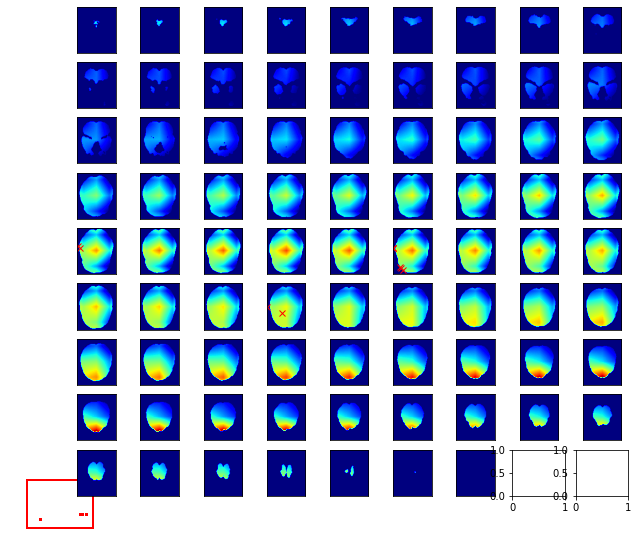

In [133]:
features = segmentation.sequential_processing(tmp.image, sliced_masks)

# RoIAlign

asdasd 3 61 (29, 33, 3, 78, 93, 61)
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
(50.018158185733405, 58.60926921062332, 27.040351523852017)
asdasd 35 36 (44, 91, 35, 45, 92, 36)
35
(44.0, 91.0, 35.0)
asdasd 28 29 (50, 89, 28, 51, 90, 29)
28
(50.0, 89.0, 28.0)
asdasd 60 61 (59, 71, 60, 60, 72, 61)
60
(59.0, 71.0, 60.0)
asdasd 15 16 (69, 42, 15, 70, 43, 16)
15
(69.0, 42.0, 15.0)
asdasd 20 21 (71, 43, 20, 72, 44, 21)
20
(71.0, 43.0, 20.0)
asdasd 39 40 (76, 48, 39, 77, 49, 40)
39
(76.0, 48.0, 39.0)


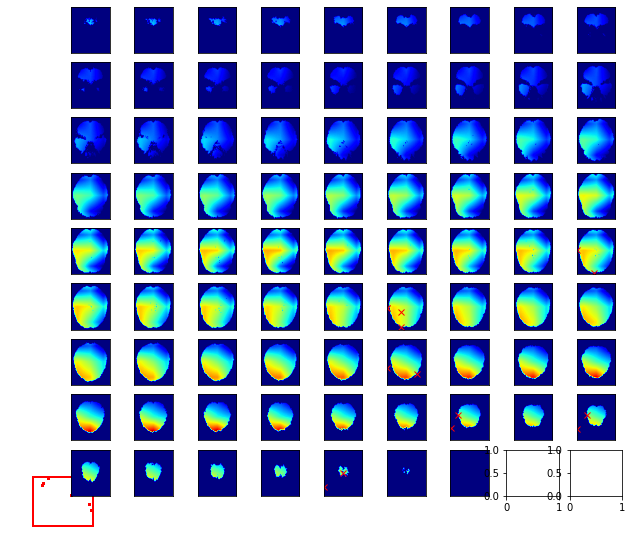

In [112]:
# Remove mask that we know are a background (not a part of the brain scan)
mask_no_background = segmentation.remove_known_background_from_mask(tmp.image, sliced_masks)

# Rescale mask and segment it
mask_mean = segmentation.mask_logarithmic_scale(mask_no_background)
segmented_mask = segmentation.segment_mask(mask_mean)

# Extract features with the intensities of the mask with removed background and plot it
features = segmentation.extract_features(segmented_mask, mask_no_background)
segmentation.plot_features_regions(features, mask_no_background)

In [ ]:
#for seg, mask in zip(segmented_mask, mask_no_background):
features = segmentation.measure.regionprops(segmented_mask, intensity_image=mask_no_background)  # only one object
#features.append(props)


In [ ]:
features[0].centroid

In [25]:
image_tensor = torch.from_numpy(tmp.image).unsqueeze(0).unsqueeze(0).float()


In [26]:
features

In [28]:
boxes = segmentation.bounding_boxes(features)


In [62]:
box_tensor = torch.stack(list(map(torch.stack, zip(*torch.Tensor(boxes))))).cuda()
image_tensor = image_tensor.cuda()

In [96]:
from src.segmentation.roi_align.roi_align import RoIAlign

roialign = RoIAlign((40,40,10),spatial_scale=1.0,sampling_ratio=-1).cuda()

image_rois = roialign.forward(image_tensor,box_tensor.cuda())

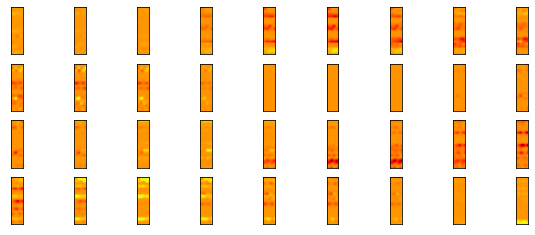

In [74]:
segmentation.display(tensor2numpy(image_rois).squeeze(1)[0].permte,step=1)

In [73]:
image_rois.squeeze(1).shape

torch.Size([6, 40, 40, 10])

In [113]:
derp = segmentation.roi_align(tmp.image, features)
# Idea: This network only support 2D (Source? https://forum.image.sc/t/weka-3d-how-is-the-depth-of-a-roi-drawn-in-2d-defined/7315/3)
# No need to use full image and not possible with multiple scans regions..

IndexError: Dimension out of range (expected to be in range of [-4, 3], but got 4)